In [682]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift

In [683]:
tpf = np.zeros((1000, 11, 11))

In [684]:
tpf[:,4:7,4:7] = 200.0
tpf += 1

for i in range(1000):
    val = 200.0*i/len(tpf)
    tpf[i,4,4:7] -= val
    tpf[i,7,4:7] += val

In [685]:
print(tpf[100,:,5])

[   1.    1.    1.    1.  181.  201.  201.   21.    1.    1.    1.]


In [780]:
lc = np.sum(tpf, axis=(1,2))
yc = np.linspace(0, 1, 1000)
xc = np.zeros(1000)

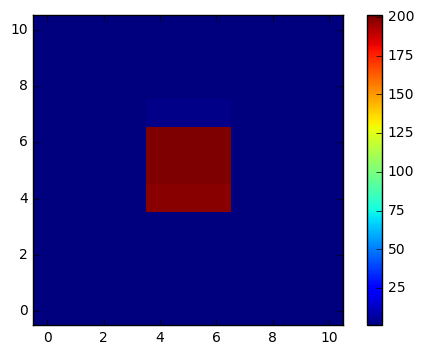

In [781]:
plt.imshow(tpf[10], origin='lower', interpolation='nearest')
plt.colorbar()

In [782]:
from scipy.interpolate import RectBivariateSpline

In [783]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [784]:
#tpf = np.log(tpf)

In [841]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]


In [842]:
super_tpf = np.array([interp[i](yp + (yc[i]), xp + (xc[i])) for i in range(len(xc))])

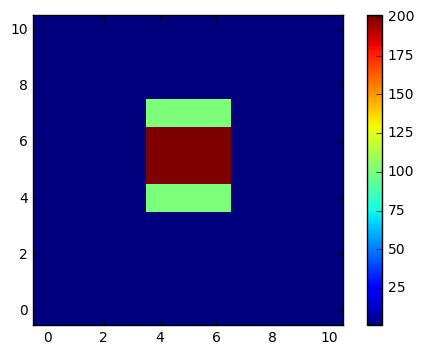

In [843]:
plt.imshow(tpf[500], origin='lower', interpolation='nearest')
plt.colorbar()

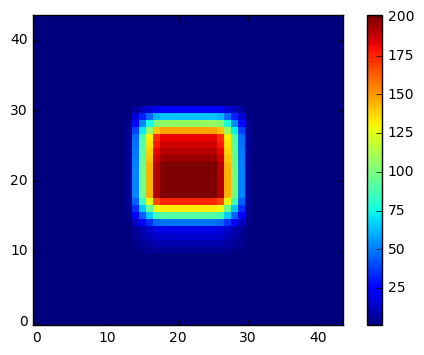

In [845]:
plt.imshow(super_tpf[900], origin='lower', interpolation='nearest')
plt.colorbar()

In [846]:
mean_super_tpf = np.mean(super_tpf, axis=0)

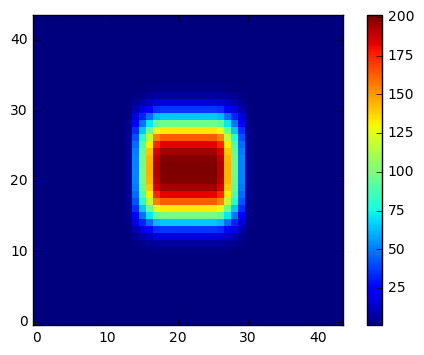

In [847]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')
plt.colorbar()

In [848]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

#norm_super_tpf = np.zeros((44,44))
#norm_super_tpf[16:28,16:28] = 1.0
#norm_super_tpf /= np.sum(norm_super_tpf)

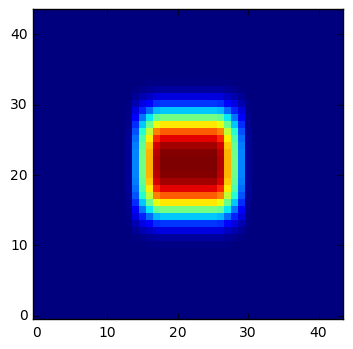

In [849]:
plt.imshow(norm_super_tpf, origin='lower', interpolation='nearest')

In [850]:
detector = np.ones((44,44))

In [851]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx)
    #interp_again = shift(template, [dy, dx], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    #return f * interp_again

In [852]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))


In [853]:
data = tpf[0]

In [854]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s)*model(1, 0, 0, template_d) + 1 - self.data
        return np.sum(r * r * 1.0)

In [855]:
from scipy.optimize import minimize
from tqdm import tqdm

print(np.shape(norm_super_tpf))

(44, 44)


In [856]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(195, 0.001*i, 0.05), args=(norm_super_tpf, detector), method='Powell')
    #print(sol.fun)
    results.append(sol.x)
    lnlike.append(sol.fun)
    #print(lnlike)

100%|██████████| 1000/1000 [00:57<00:00, 18.69it/s]


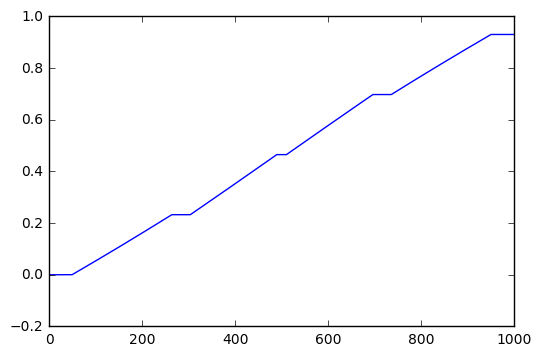

In [857]:
results = np.array(results)
plt.plot(results[:,1])

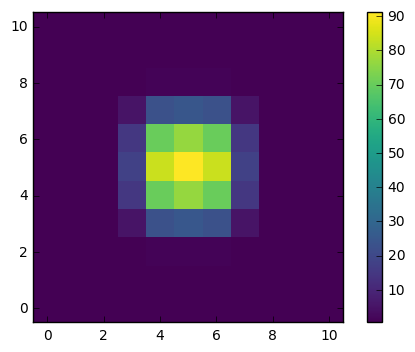

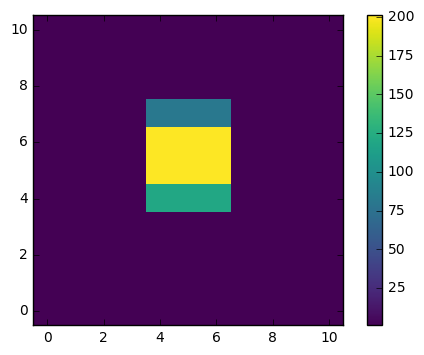

[  2.71828183e+00   2.71828183e+00   2.71828183e+00   2.71828183e+00
   3.54513118e+52   1.96422332e+87   1.96422332e+87   1.50609731e+35
   2.71828183e+00   2.71828183e+00   2.71828183e+00]
[  0.4548578    0.4548578    1.18624495  22.91330653  70.4304135
  83.71439318  70.39394156  22.86577422   1.18178741   0.4548578
   0.4548578 ]
[  2.84286123e-05   2.84286123e-05   2.84286123e-05   2.84286123e-05
   2.84286123e-05   2.84286123e-05   2.84286123e-05   2.84286123e-05
   2.84286123e-05   2.84286123e-05   2.84286123e-05   2.84286123e-05
   2.84286123e-05   1.35447609e-04   1.20563758e-03   2.27582755e-03
   3.34601752e-03   4.41620749e-03   4.63024548e-03   4.63024548e-03
   4.63024548e-03   4.63024548e-03   4.63024548e-03   4.63024548e-03
   4.63024548e-03   4.63024548e-03   4.41620749e-03   3.34601752e-03
   2.27582755e-03   1.20563758e-03   1.35447609e-04   2.84286123e-05
   2.84286123e-05   2.84286123e-05   2.84286123e-05   2.84286123e-05
   2.84286123e-05   2.84286123e-05   2.8428

In [858]:
model_ = model(1000, 0.0, 0.0, norm_super_tpf)
#model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(model_, origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()
#plt.imshow(mode, origin='lower', interpolation='nearest', cmap='viridis')
#plt.show()
plt.imshow(tpf[400], origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()

print(np.exp(tpf[400,:,5]))
print(model_[:,6])
print(norm_super_tpf[17])


In [859]:
logL = lnlikelihood(data=tpf[400])
print(logL.evaluate((45.67, 1.6, 0.0), norm_super_tpf, detector))

198717.236467


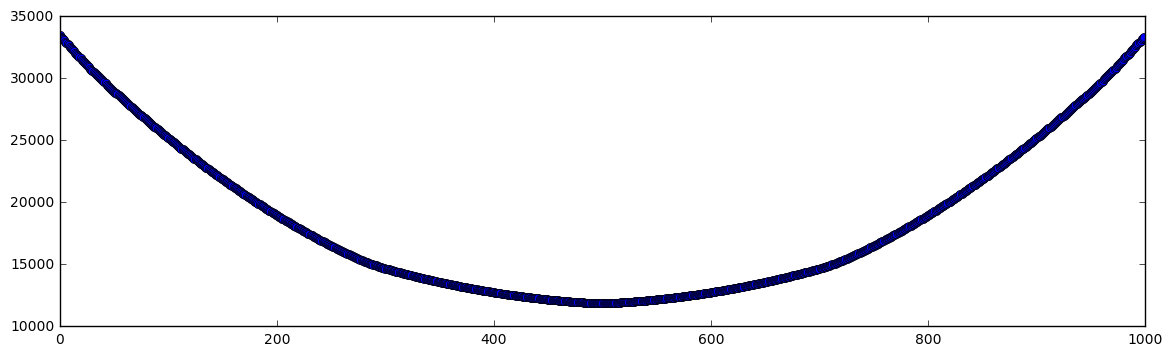

In [860]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [861]:
gds = norm_super_tpf

In [862]:
models = [model(*results[i], gds) for i in range(1000)]
interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]



In [863]:
#interp_ = RectBivariateSpline(x, y, model_ - tpf[0], kx=1, ky=1)

In [864]:
dlnlike_ds = 2 * np.array([results[i, 0] * interps[i](yp - results[i, 1], xp - results[i, 2]) for i in range(1000)])

In [865]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

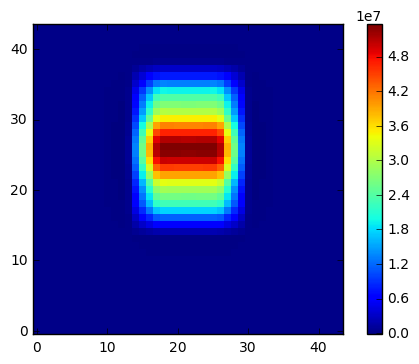

In [866]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [867]:
gds = np.copy(norm_super_tpf)

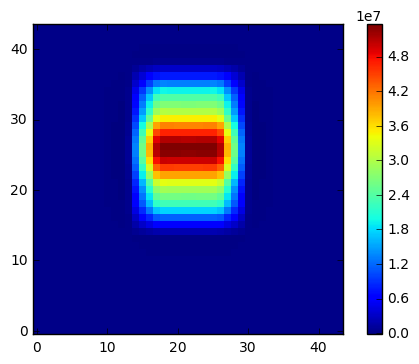

In [868]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [883]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-11
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) + 1 for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 2000:
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) + 1 for i in range(1000)]
            interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
            dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
            dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [884]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s) * model(1, 0, 0, tmp_d) + 1 for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], template_s) * model(1, 0, 0, tmp_d) + 1 for i in range(1000)]
            interps = [shift(models[i] - tpf[i], [yp, xp], output=None, order=1, mode='constant', 
                     cval=0.0, prefilter=False) for i in range(tpf.shape[0])]
            dlnlike_dd = 2 * np.array([f_n[i] * interps[i] for i in range(1000)])
            dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

In [885]:
results = np.array(results)
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))


6027790.33973
5980693.70724
5980693.70724
5944304.9224
5944304.9224
5920824.67634
5920824.67634
5912685.46792
5912685.46792
5922618.70832
5922618.70832
5929645.01231
5929645.01231
5931685.52542
5931685.52542
5932213.39977
5932213.39977
5932346.47749
5932346.47749
5932379.81624


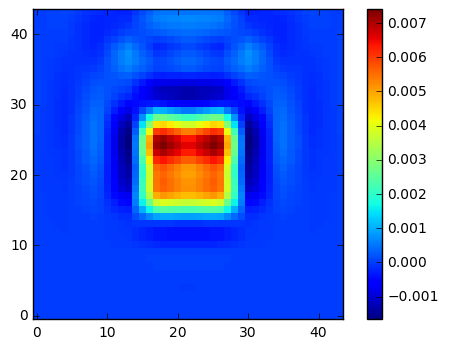

In [886]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

In [876]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

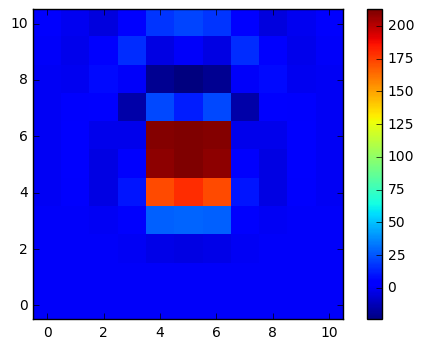

In [877]:
n=-999
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) * model(1, 0, 0, detector) + 1, origin='lower', interpolation='nearest')
plt.colorbar()

In [878]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:53<00:00, 11.40it/s]


In [879]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)) for i in range(1000)] 

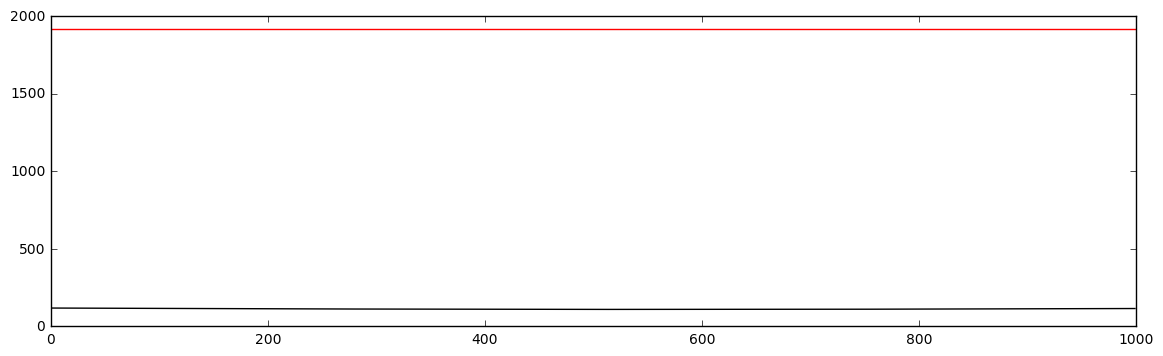

In [881]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')

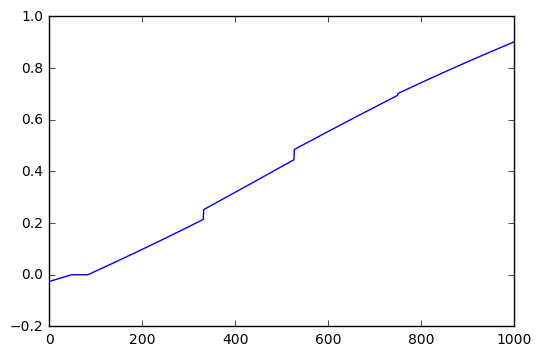

In [882]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,1])

1920.9999975547826

What have we learned? This works *perfectly* when the star is not moving. This is a good thing!
When the star is moving, this is not working perfectly. Need to trace down why and figure out how to stop it.